<a href="https://colab.research.google.com/github/mehrotrasan16/Keras-Deep-Learning/blob/02-horsesvhumans-MobileNetV2Finetune-BinaryClassification/A2_Q3_MobileNetV2_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

# Loading and Preprocessing the Data

In [2]:

(raw_data, raw_validation,raw_test), metadata = tfds.load(
    'horses_or_humans',
    split=['train[:80%]','train[80%:90%]','test'],
    with_info=True,
    as_supervised=True
)  

In [3]:
print(raw_data,raw_validation,raw_test)

<DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)> <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)> <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>


In [4]:
get_label_name = metadata.features['label'].int2str

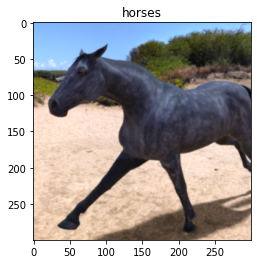

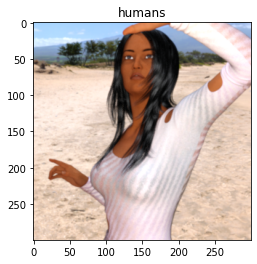

In [5]:
for image,label in raw_data.shuffle(1024).take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [6]:
IMG_SIZE=160

def format_example(image,label):
    image=tf.cast(image,tf.float32)
    #normalizing the values
    image=(image/127.5) - 1
    #scaling the image
    image=tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
    return image,label

In [7]:
train = raw_data.map(format_example)
validation=raw_validation.map(format_example)
test=raw_test.map(format_example)

In [8]:
validation,test

(<DatasetV1Adapter shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>,
 <DatasetV1Adapter shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>)

In [9]:
BATCH_SIZE=32
SHUFFLE_BUFFER_SIZE=1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches=validation.batch(BATCH_SIZE)
test_batches=test.batch(BATCH_SIZE)

for image_batch,label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([32, 160, 160, 3])

In [10]:
IMG_SHAPE=(IMG_SIZE,IMG_SIZE,3)

base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
feature_batch=base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [11]:
base_model.trainable=False

global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [12]:
prediction_layer = keras.layers.Dense(1)
prediction_batch=prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [13]:
model=keras.Sequential([
                        base_model,
                        global_average_layer,
                        prediction_layer
])

In [14]:
base_learning_rate=0.0001
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=base_learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics='accuracy'
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
checkpoint_filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [17]:
initial_epochs=10
history = model.fit(
    train_batches,
    epochs=initial_epochs,
    validation_data=validation_batches,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
     26/Unknown - 1s 57ms/step - loss: 0.5515 - accuracy: 0.6873WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 3s 124ms/step - loss: 0.5515 - accuracy: 0.6873 - val_loss: 0.4831 - val_accuracy: 0.7843
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.4034 - accuracy: 0.8431WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 72ms/step - loss: 0.4034 - accuracy: 0.8431 - val_loss: 0.3694 - val_accuracy: 0.9412
Epoch 3/10
25/26 [===========================>..] - ETA: 0s - loss: 0.3010 - accuracy: 0.9325WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 71ms/step - loss: 0.2999 - accuracy: 0.9343 - val_loss: 0.2824 - val_accuracy: 0.9510
Epoch 4/10
25/26 [===========================>..] - ETA: 0s - loss: 0.2242 - accuracy: 0.9725WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 69ms/step - loss: 0.2226 - accuracy: 0.9732 - val_loss: 0.2156 - val_accuracy: 0.9804
Epoch 5/10
25/26 [===========================>..] - ETA: 0s - loss: 0.1656 - accuracy: 0.9950WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 71ms/step - loss: 0.1649 - accuracy: 0.9951 - val_loss: 0.1643 - val_accuracy: 0.9902
Epoch 6/10
25/26 [===========================>..] - ETA: 0s - loss: 0.1235 - accuracy: 0.9975WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 69ms/step - loss: 0.1225 - accuracy: 0.9976 - val_loss: 0.1285 - val_accuracy: 0.9902
Epoch 7/10
26/26 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9976WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 70ms/step - loss: 0.0913 - accuracy: 0.9976 - val_loss: 0.0986 - val_accuracy: 1.0000
Epoch 8/10
26/26 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 70ms/step - loss: 0.0685 - accuracy: 1.0000 - val_loss: 0.0787 - val_accuracy: 1.0000
Epoch 9/10
26/26 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 70ms/step - loss: 0.0517 - accuracy: 1.0000 - val_loss: 0.0626 - val_accuracy: 1.0000
Epoch 10/10
25/26 [===========================>..] - ETA: 0s - loss: 0.0389 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


26/26 [==============================] - 2s 70ms/step - loss: 0.0393 - accuracy: 1.0000 - val_loss: 0.0496 - val_accuracy: 1.0000


In [18]:
model.evaluate(test_batches)

8/8 [==============================] - 1s 83ms/step - loss: 0.0487 - accuracy: 1.0000


[0.048731379210948944, 1.0]

# Fine Tuning

In [19]:
base_model.trainable=True

print('Number of lauers in the base model: ',len(base_model.layers))

finetune_at=155

Number of lauers in the base model:  155


In [20]:
for layer in base_model.layers[:finetune_at]:
    layer.trainable=False

In [21]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy']
              )

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
fine_tuning_epochs=10
total_epochs=initial_epochs+fine_tuning_epochs

histroy_fine=model.fit(
train_batches,
epochs=total_epochs,
initial_epoch=history.epoch[-1],
validation_data=validation_batches
)

Epoch 10/20
26/26 [==============================] - 3s 97ms/step - loss: 0.0333 - accuracy: 1.0000 - val_loss: 0.0485 - val_accuracy: 1.0000
Epoch 11/20
26/26 [==============================] - 2s 70ms/step - loss: 0.0322 - accuracy: 1.0000 - val_loss: 0.0476 - val_accuracy: 1.0000
Epoch 12/20
26/26 [==============================] - 2s 70ms/step - loss: 0.0313 - accuracy: 1.0000 - val_loss: 0.0467 - val_accuracy: 1.0000
Epoch 13/20
26/26 [==============================] - 2s 69ms/step - loss: 0.0304 - accuracy: 1.0000 - val_loss: 0.0459 - val_accuracy: 1.0000
Epoch 14/20
26/26 [==============================] - 2s 71ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.0451 - val_accuracy: 1.0000
Epoch 15/20
26/26 [==============================] - 2s 69ms/step - loss: 0.0287 - accuracy: 1.0000 - val_loss: 0.0442 - val_accuracy: 1.0000
Epoch 16/20
26/26 [==============================] - 2s 73ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 1.0000
Epoch 

In [24]:
model.evaluate(test_batches)

8/8 [==============================] - 1s 86ms/step - loss: 0.0370 - accuracy: 1.0000


[0.03703619912266731, 1.0]